symbol         alpha      beta    spread    zscore  pos_X  pos_Y        pnl_$  \
date                                                                            
2025-08-25  7.739375  0.752002 -2.325957 -1.789798    1.0   -1.0 -5115.714343   
2025-08-26  7.840827  0.739121 -2.119394 -1.588097    1.0   -1.0  5178.837446   
2025-08-27  7.897395  0.730576 -1.946695 -1.411023    1.0   -1.0  -692.721859   
2025-08-28  7.940286  0.722807 -1.955027 -1.392685    1.0   -1.0  2041.929686   
2025-08-29  8.034882  0.711635 -1.846983 -1.290804    1.0   -1.0   -84.198996   

symbol              cum_$  
date                       
2025-08-25  242663.355767  
2025-08-26  247842.193213  
2025-08-27  247149.471354  
2025-08-28  249191.401040  
2025-08-29  249107.202044  


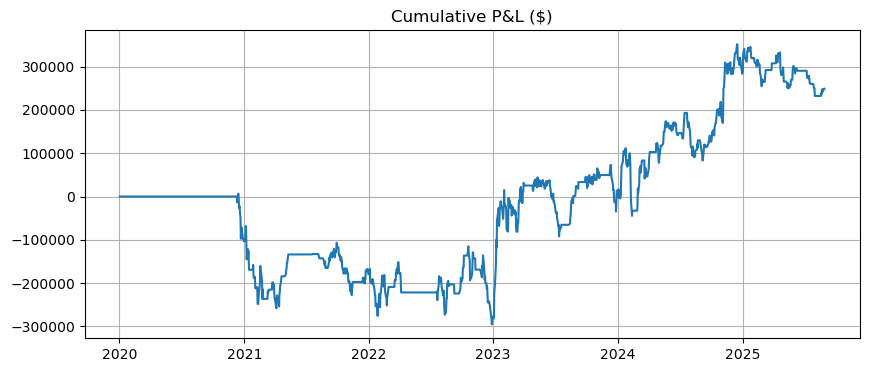

In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from openbb import obb
import matplotlib.pyplot as plt
obb.user.preferences.output_type = "dataframe"

pair = ["MARA", "RIOT"]

# 1) Load wide prices
df = obb.equity.price.historical(
    pair,
    start_date="2020-01-01",
    end_date="2025-08-31",
    provider="yfinance"
).pivot(columns="symbol", values="close").sort_index()

# 2) Rolling OLS hedge ratio with intercept
lookback = 120
def roll_ols(y, x):
    X = sm.add_constant(x)
    try:
        fit = sm.OLS(y, X).fit()
        return fit.params[0], fit.params[1]
    except Exception:
        return np.nan, np.nan

alphas = pd.Series(np.nan, index=df.index)
betas  = pd.Series(np.nan, index=df.index)
for i in range(lookback-1, len(df)):
    yw = df[pair[0]].iloc[i-lookback+1:i+1].values
    xw = df[pair[1]].iloc[i-lookback+1:i+1].values
    a, b = roll_ols(yw, xw)
    alphas.iat[i] = a
    betas.iat[i]  = b

df["alpha"] = alphas
df["beta"]  = betas.ffill()  # propagate early NaNs

# 3) Spread and z-score
df["spread"] = df[pair[0]] - (df["alpha"] + df["beta"] * df[pair[1]])
df["spread_mu"]  = df["spread"].rolling(lookback).mean()
df["spread_std"] = df["spread"].rolling(lookback).std(ddof=1)
df["zscore"] = (df["spread"] - df["spread_mu"]) / df["spread_std"]

# 4) Entries and exits (use small hysteresis near zero)
entry = 0.7
exit_band = 0.1  # small band to avoid constant flatten at 0
df["long_entry"]  = (df["zscore"] <= -entry).astype(int)
df["short_entry"] = (df["zscore"] >=  entry).astype(int)
df["long_exit"]   = (df["zscore"] >= -exit_band).astype(int)   # exit long when reverted above -0.1
df["short_exit"]  = (df["zscore"] <=  exit_band).astype(int)   # exit short when reverted below +0.1

# 5) Accumulate positions and flatten on exit
df["pos_X"] = 0.0
df["pos_Y"] = 0.0

pos_X = 0.0
pos_Y = 0.0
for i, (le, se, lx, sx) in enumerate(zip(
    df["long_entry"].values,
    df["short_entry"].values,
    df["long_exit"].values,
    df["short_exit"].values
)):
    # Flatten if exit condition
    if lx == 1 or sx == 1:
        pos_X = 0.0
        pos_Y = 0.0
    # Stack a new unit for entries
    if le == 1:
        pos_X += 1.0
        pos_Y -= 1.0
    elif se == 1:
        pos_X -= 1.0
        pos_Y += 1.0
    # Write positions (use iat for safe scalar assignment)
    df.iat[i, df.columns.get_loc("pos_X")] = pos_X
    df.iat[i, df.columns.get_loc("pos_Y")] = pos_Y

# 6) Returns and PnL (apply beta in PnL, with 1-bar delay)
rets = df[pair].pct_change().fillna(0.0)
beta_exec = df["beta"].shift(1).ffill().fillna(1.0)
pos_X_exec = df["pos_X"].shift(1).fillna(0.0)
pos_Y_exec = df["pos_Y"].shift(1).fillna(0.0)

df["pnl"] = pos_X_exec * rets[pair[0]] - beta_exec * pos_Y_exec * rets[pair[1]]

# 7) Scale and plot
notional = 100_000.0
df["pnl_$"] = notional * df["pnl"]
df["cum_$"] = df["pnl_$"].cumsum()

cols = ["alpha","beta","spread","zscore","pos_X","pos_Y","pnl_$","cum_$"]
print(df[cols].tail())

plt.figure(figsize=(10,4))
plt.plot(df.index, df["cum_$"])
plt.title("Cumulative P&L ($)")
plt.grid(True)
plt.show()
